# VAE Part

## Imports and initialisation

In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
# read the parquet files in the data folder
full_data = pd.read_parquet('../data/train-0.parquet')
full_data

In [ ]:
# symbols occur in the data
symbols = full_data['symbol_id'].value_counts().index.tolist()
symbols

## Overview of features importances and model sensitivity to symbol

In [133]:
def data_preprocess(symbol, data):
    # Define columns to exclude
    exclude_cols = ['date_id', 'time_id'] + [f'responder_{i}' for i in range(0, 9)]

    # Filter data for the selected symbol
    df = data[data['symbol_id'] == symbol]

    # Create lags
    for lag in [1, 2, 3]:
        df[f'responder_6_lag{lag}'] = df['responder_6'].shift(lag)
    
    # Drop rows with NaN
    df = df.dropna(subset=[f'responder_6_lag{lag}' for lag in [1, 2, 3]])

    # Separate features and target
    X = df.drop(columns=exclude_cols)
    y = df['responder_6']

    return X,y

def train_model_xgboost(symbol, data):
    # Data preprocessing
    X, y = data_preprocess(symbol, data)
    X['symbol_id'] = X['symbol_id'].astype('category')

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Convert to DMatrix
    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
    dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

    # Training of a XGBoost model with verbose evaluation
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'seed': 42
    }
    evals = [(dtrain, 'train'), (dtest, 'eval')]
    model = xgb.train(params, dtrain, num_boost_round=1000, evals=evals, early_stopping_rounds=10, verbose_eval=10)
    
    # Predictions
    y_pred = model.predict(dtest)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Final RMSE: {rmse:.4f}")

    return model, rmse

In [ ]:
# create as many xgboost models as there are symbols and compare the results

rmse = {}
features_importances = {}

for symbol in symbols:
    print(f"Predictions for symbol {symbol}")

    # Train XGBoost model and evaluate rmse
    model, rmse[f'symbol_{symbol}'] = train_model_xgboost(symbol, full_data)

    # save the feature importances
    importances = model.get_score(importance_type='weight')
    features_names = model.get_score(importance_type='weight').keys()

    for features in features_names:
        if features in features_importances:
            features_importances[f'{features}'].append(importances[features])
        else:
            features_importances[f'{features}'] = [importances[features]]
 
 # Plot RMSE Bar Chart and Feature Importance Boxplot

# RMSE Bar Chart
plt.figure(figsize=(10, 6))
plt.bar(rmse.keys(), rmse.values())
plt.xlabel('Symbol')
plt.ylabel('RMSE')
plt.title('RMSE for each symbol')
plt.show()

# Feature Importance Boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(features_importances.values())
plt.xticks(range(1, len(features_importances) + 1), features_importances.keys(), rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance for each symbol')
plt.show()


## XGBoost based model on all symbols

## Building a VAE

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim.adam import Adam
from torch.utils.data import Dataset, DataLoader, random_split

In [ ]:
def data_preprocess(symbol, data):

    # Filter data for the selected symbol
    df = data[data['symbol_id'] == symbol]
    # Create lags
    for lag in [1, 2, 3]:
        df[f'responder_6_lag{lag}'] = df['responder_6'].shift(lag)
    
    # Drop rows with NaN
    df.dropna(subset=[f'responder_6_lag{lag}' for lag in [1, 2, 3]], inplace=True)

    # Handling missing values
    # if more than 50% of the values in a column are missing, drop the column
    missing_values = df.isnull().mean()
    missing_values = missing_values[missing_values > 0.5]
    df.drop(columns=missing_values.index, inplace=True)
    # if less than 50% of the values in a column are missing, fill the missing values with the previous value and the next value 
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)

    # Once all NaN are filled, drop the columns that have a standard deviation of 0 to prevent division by zero during scaling
    
    exclude_cols = ['symbol_id','date_id', 'time_id'] + [f'responder_{i}' for i in range(9) if i != 6]
    df.drop(columns=exclude_cols, inplace=True)
    std = df.std()
    exclude_cols = std[std == 0].index 
    df.drop(columns=exclude_cols, inplace=True)

    return df

In [ ]:
# Create class KaggleDataset which is a child of Dataset class from torch.util.data

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class KaggleDataset(Dataset):
    
    def __init__(self, df):
        """
        Args:
            df (pd.DataFrame): DataFrame containing the data
        """
        # Store the preprocessed DataFrame in self.dataframe (for symbol 0)
        self.dataframe = data_preprocess(0, df) 

        # Extract the features for easier manipulation
        self.features = self.dataframe.values

        # Calculate mean and std for normalization
        self.mean = self.features.mean(axis=0)
        self.std = self.features.std(axis=0)

        # Apply normalization to features
        self.features = (self.features - self.mean) / self.std

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        
        # Return the item at index idx in the form of tensor
        features = torch.tensor(self.features[idx], dtype=torch.float32).to(device)
        return features

# Create a KaggleDataset object
dataset = KaggleDataset(full_data)

# Then, the batch_size and input_dim were set. The dataset was divided into train and test datasets. Each of these was loaded into a DataLoader. The device was set to ‘cuda’ if available. 

In [ ]:
# Define batchsize and input dimensions
batch_size = 64
input_dim = dataset.features.shape[1]
latent_dim = input_dim - 5
hidden_dim = (latent_dim + input_dim) // 2
# Define learning rate
learning_rate = 1e-3

# Split dataset into train and test without shuffle in the ratio of 80:20
train_dataset, test_dataset = random_split(dataset, [0.8,0.2])

# Use DataLoader for batching and shuffling
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, device=device):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )
        
        # Latent mean and variance 
        self.mean_layer = nn.Linear(latent_dim, 1)
        self.logvar_layer = nn.Linear(latent_dim, 1)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(1, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim)
            )
    # Encode function
    def encode(self, x):
        x = self.encoder(x)
        mean, log_var = self.mean_layer(x), self.logvar_layer(x)
        return mean, log_var
    
    # Add Reparameterization
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)      
        z = mean + var*epsilon
        return z

    # Decode function
    def decode(self, x):
        return self.decoder(x)

    # Forward Function
    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, log_var)
        x_hat = self.decode(z)
        return x_hat, mean, log_var
    
    # Reconstruct input from compressed form
    def reconstruction(self, mean, log_var):
        z = self.reparameterization(mean, log_var)
        x_hat = self.decode(z)
        return x_hat


In [ ]:
def loss_function(x, x_hat, mean, log_var):
    # Reproduction Loss
    reproduction_loss = nn.functional.mse_loss(x_hat, x)
    # KL Divergence Loss
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KLD

# VAE Model created and stored in device
model = VAE(input_dim = input_dim,hidden_dim=hidden_dim,  latent_dim=latent_dim).to(device)

# Optimizer defined
optimizer = Adam(model.parameters(), lr=learning_rate)

In [ ]:
def train(model, optimizer, epochs, device):
    
    # Set model to training mode
    model.train()
    
    # Loop for each epoch
    for epoch in range(epochs):
        overall_loss = 0
        
        # Iterate over the batches formed by DataLoader
        for batch_idx, x in enumerate(train_dataloader):
            x = x.to(device)
            
            # Reset Gradient
            optimizer.zero_grad()
            x_hat, mean, log_var = model(x)
            
            # Calculate batch loss and then overall loss
            loss = loss_function(x, x_hat, mean, log_var)
            overall_loss += loss.item()
            
            # Backpropagate the loss and train the optimizer
            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss

# Train the model for 5 epochs
train(model, optimizer, epochs=5, device=device)

In [ ]:
def predict(model, test_dataloader=test_dataloader):
    
    # Set model to evaluation mode
    model.eval()
    dataset_size = 0
    
    # Set up torch so there is no gradient upgrade
    with torch.no_grad():
        overall_loss=0
        all_mean = None
        all_log_var = None
        
        # Iterate over batches of test dataset
        for batch_idx, x in enumerate(test_dataloader):
            
            # Get reconstructed value, mean and log_var
            x_hat, mean, log_var  = model(x)
            
            # Calculate loss
            loss = loss_function(x, x_hat, mean, log_var)
            
            # Add mean and log_var to arrays
            if all_mean is not None:
                all_mean = torch.cat((all_mean, mean))
                all_log_var = torch.cat((all_log_var, log_var))
            else:
                all_mean = mean
                all_log_var = log_var
            
            # Add loss 
            overall_loss += loss.item()
            
            # Calculate the size of the dataset
            size_batch = x.element_size() * x.numel()
            dataset_size += size_batch

        # Calculate the size after compression of the dataset
        compressed_size = (all_mean.element_size() * all_mean.numel()) + (all_log_var.element_size() * all_log_var.numel())

        print("\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
        print(f"\tDataset Size: {dataset_size} \n\tCompressed Size: {compressed_size}")
        print("\tCompression Ratio: ", compressed_size/dataset_size)

        return all_mean, all_log_var
    
# Predict the values for test dataset and calculate compression ratio
mean,var = predict(model)

# Reconstruct the input from compressed form
x_hat = model.reconstruction(mean, var)

# reparameterization of x_hat to obtain the reconstructed values of the input

df_hat = pd.DataFrame(x_hat.detach().numpy(), columns=dataset.dataframe.columns)


In [ ]:
from itertools import product

# Build a cross-validation grid search for our VAE model

# Define the hyperparameters to search
hyperparameters = {
    'hidden_dim': [input_dim - 1 , input_dim - 3],
    'latent_dim': [input_dim - 10, input_dim - 20],
    'learning_rate': [1e-3, 1e-4],
    'batch_size': [64, 128]
}

# Define the number of epochs
epochs = 5

# Define the number of folds for cross-validation
n_splits = 2

# Create a list of all hyperparameter combinations
keys, values = zip(*hyperparameters.items())
combinations = [dict(zip(keys, v)) for v in product(*values)]

# Create a list of models and their corresponding hyperparameters
models = []
for combination in combinations:
    model = VAE(input_dim=input_dim, hidden_dim=combination['hidden_dim'], latent_dim=combination['latent_dim']).to(device)
    optimizer = Adam(model.parameters(), lr=combination['learning_rate'])
    models.append((model, optimizer, combination))

# Cross-validation for each model
for model, optimizer, combination in models:
    print(f"Training model with hyperparameters: {combination}")
    for fold, (train_idx, test_idx) in enumerate(TimeSeriesSplit(n_splits=n_splits).split(dataset)):
        train_dataset = torch.utils.data.Subset(dataset, train_idx)
        test_dataset = torch.utils.data.Subset(dataset, test_idx)
        train_dataloader = DataLoader(train_dataset, batch_size=combination['batch_size'], shuffle=False)
        test_dataloader = DataLoader(test_dataset, batch_size=combination['batch_size'], shuffle=False)
        train(model, optimizer, epochs, device=device)
        mean, var = predict(model, test_dataloader)
        print(f"Model with hyperparameters {combination} and fold {fold} has been trained and evaluated.")
        print("-------------------------------------------------------------")

In [ ]:
# create a single xgboost model for all symbols
max_lag = 4

# create the lagged responder_6 columns
for lag in range(1, max_lag + 1):
    full_data[f'responder_6_lag{lag}'] = full_data.groupby('symbol_id')['responder_6'].shift(lag)

# drop rows with NaN
full_data.dropna(subset=[f'responder_6_lag{lag}' for lag in range(1, max_lag + 1)])

# separate features and target

exclude_cols = ['date_id', 'time_id'] + [f'responder_{i}' for i in range(0, 9)]
X = full_data.drop(columns=exclude_cols)
y = full_data['responder_6']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# convert to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

# train the model
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'seed': 42
}
evals = [(dtrain, 'train'), (dtest, 'eval')]
model = xgb.train(params, dtrain, num_boost_round=1000, evals=evals, early_stopping_rounds=10, verbose_eval=10)

# predict the test set
y_pred = model.predict(dtest)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Final RMSE: {rmse:.4f}")

# plot feature importance in ascending order
sorted_importances = {k: v for k, v in sorted(importances.items(), key=lambda item: item[1])}

plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.bar(sorted_importances.keys(), sorted_importances.values())
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

# plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Index')
plt.ylabel('Responder 6')
plt.title('Predictions vs Actual Values')
plt.legend()
plt.show()

## XGboost benchmarking differents dimension reduction methods

In [65]:
# preprocess the data into features and target

def data_preprocess(data, symbol=None):

    if symbol is not None:
        # Filter data for the selected symbol
        df = data[data['symbol_id'] == symbol]
    else:
        df = data

    # Create lags
    for lag in [1, 2, 3]:
        df[f'responder_6_lag{lag}'] = df.groupby('symbol_id')['responder_6'].shift(lag)
    
    # Drop rows with NaN
    df.dropna(subset=[f'responder_6_lag{lag}' for lag in [1, 2, 3]], inplace=True)

    # Drop columns with more than 50% missing values
    missing_values = df.isnull().mean()
    missing_values = missing_values[missing_values > 0.5]
    df.drop(columns=missing_values.index, inplace=True)

    # Drop columns not needed
    exclude_cols = ['date_id', 'time_id'] + [f'responder_{i}' for i in range(9) if i != 6]
    df.drop(columns=exclude_cols, inplace=True)

    # Fill missing values with previous and next values
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)

    # Drop columns with zero standard deviation
    std = df.std()
    exclude_cols = std[std == 0].index.tolist()

    # Separate features and target
    X = df.drop(columns=exclude_cols + ['responder_6'])
    y = df['responder_6']

    return X, y


In [66]:
# disable the warnings
import warnings
warnings.filterwarnings('ignore')

X,y = data_preprocess(full_data, symbol=0)


In [40]:

# dimensionality reduction with PCA, and Autoencoder
dim = X.shape[1] // 2

# Normaliser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# Fonction pour évaluer les performances du modèle
def evaluate_model(X_train, X_test, y_train, y_test):
    model = xgb.XGBRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Évaluer le modèle sans réduction de la dimensionnalité
mse = evaluate_model(X_train, X_test, y_train, y_test)

# Réduction de la dimensionnalité avec PCA
pca = PCA(n_components=dim)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
mse_pca = evaluate_model(X_train_pca, X_test_pca, y_train, y_test)


# Réduction de la dimensionnalité avec un autoencodeur
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, z

input_dim = X_train.shape[1]
latent_dim = dim
autoencoder = Autoencoder(input_dim, latent_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Convertir les données en tenseurs PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Entraîner l'autoencodeur
num_epochs = 10
for epoch in range(num_epochs):
    autoencoder.train()
    optimizer.zero_grad()
    X_reconstructed, X_latent = autoencoder(X_train_tensor)
    loss = criterion(X_reconstructed, X_train_tensor)
    loss.backward()
    optimizer.step()

# Obtenir les représentations latentes
autoencoder.eval()
with torch.no_grad():
    _, X_train_latent = autoencoder(X_train_tensor)
    _, X_test_latent = autoencoder(X_test_tensor)

X_train_latent = X_train_latent.numpy()
X_test_latent = X_test_latent.numpy()
mse_autoencoder = evaluate_model(X_train_latent, X_test_latent, y_train, y_test)

# Afficher les résultats
print(f"MSE without dimension reduction: {mse}")
print(f"MSE with PCA: {mse_pca}")
print(f"MSE with Autoencoder: {mse_autoencoder}")

MSE without dimension reduction: 0.17314575612545013
MSE with PCA: 0.2003675401210785
MSE with Autoencoder: 0.31443125009536743


## SUAVE-ML VAE

In [74]:
from suave import SuaveClassifier

# Preparing data for SuaveClassifier
# transforming the target variable into a 5 bins classification problem
Y = pd.concat([y, pd.qcut(y, 5, labels=False)], axis=1, keys=['responder_6', 'target'])
target = pd.DataFrame(Y['target'])
# Splitting the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, target, test_size=0.2, shuffle=False)


In [81]:
# convert the data into dataframes
Y_train = pd.DataFrame(Y_train, columns=['target'])
Y_test = pd.DataFrame(Y_test, columns=['target'])

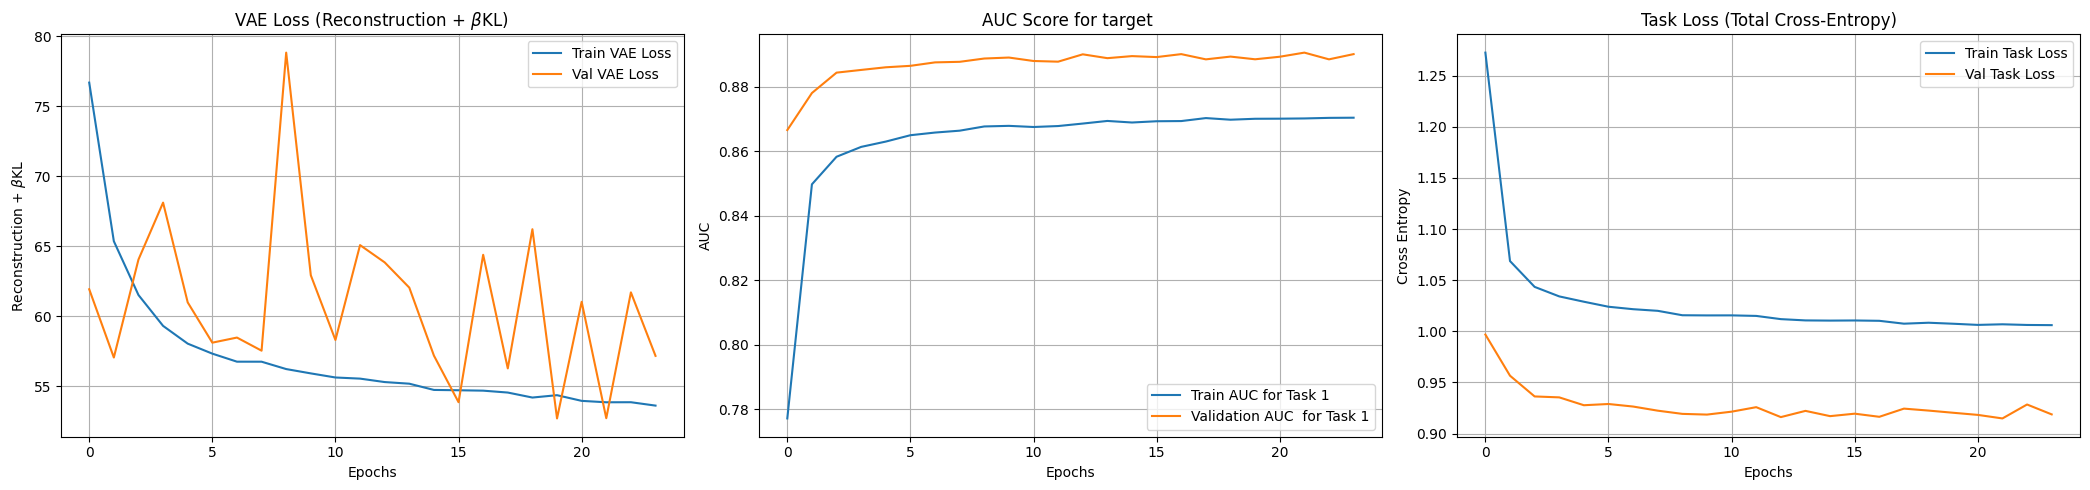

Training:  24%|██▍       | 24/100 [1:20:59<1:43:47, 81.94s/epoch, VAE(t)=53.601, VAE(v)=57.157, AUC(t)=[0.87], AUC(v)=[0.89]]

In [ ]:

# Instantiate the model
model = SuaveClassifier(input_dim=X_train.shape[1],             # Input feature dimension
                        task_classes=[len(Y_train['target'].unique())],   # Number of binary classification tasks
                        latent_dim=input_dim//2                 # Latent dimension
                        )

# Fit the model on training data
model.fit(X_train, Y_train, epochs=100, animate_monitor=True, verbose=1)


In [ ]:


# Make predictions on test data
y_probas = model.predict_proba(X_test)
y_hats = model.predict(X_test)

auc_scores = model.score(X_test, Y_test)
print("AUC Scores:", auc_scores)

# Transform features to latent space
latent_features = model.transform(np.array(X_test))
X_latent = pd.DataFrame(latent_features, index=X_test.index, columns=[f'latent_feature {i+1}' for i in range(10)]) # number of columns should be the same as `latent_dim`

# Reconstruct input from latent space
reconstructed = model.inverse_transform(latent_features)
X_reconstructed = pd.DataFrame(reconstructed, index=X_test.index, columns=X_test.columns)
